# Setup

In [ ]:
### data from

# DEPTH_DATA_URL="https://www.dropbox.com/s/qtab28cauzalqi7/depth_data.tar.gz?dl=1"
# DATA_EXTRACT_DIR="./content"

# !wget -c $DEPTH_DATA_URL -O - | tar -xz -C $DATA_EXTRACT_DIR

# !cp -r /content/drive/MyDrive/Themis\ AI/paper/depth_data.tar.gz /content/
# !mkdir /content/data
# !tar -xzvf /content/depth_data.tar.gz -C /content/data/

depth_train.h5
apolloscape_test.h5
depth_test.h5


In [1]:
#@title utils

def visualize_depth_map(x, y, model=None):
    cmap = plt.cm.jet
    cmap.set_bad(color="black")

    pred = model.predict(x)
    fig, ax = plt.subplots(16, 3, figsize=(50, 50))
    for i in range(16):
        ax[i, 0].imshow(x[i])
        ax[i, 1].imshow(y[i, :, :, 0], cmap=cmap)
        ax[i, 2].imshow(pred[i, :, :, 0], cmap=cmap)


def plot_loss(history):
    for k, v in history.history.items():
        plt.plot(v, label=k)
    plt.legend(loc='upper right')
    plt.show()
    
def get_user_model():
    return tf.keras.Sequential([
        tf.keras.Input(shape=(1,)),
        layers.Dense(16, 'relu'), 
        layers.Dense(32, 'relu'), 
        layers.Dense(64, 'relu'), 
        layers.Dense(32, 'relu'), 
        layers.Dense(16, 'relu'), 
        layers.Dense(1, None),
    ])

def plot_loss(history):
    for k, v in history.history.items():
        plt.plot(v, label=k)
    plt.legend(loc='upper right')
    plt.show()

def get_preds_names(history):
    l = list(history.history.keys())
    # cut of keras metric names -- e.g., 'MVEW_0_loss' -> 'MVEW_0'
    l_split = [i.rsplit('_', 1)[0] for i in l]
    # remove duplicates (if specified multiple keras metrics)
    return list(dict.fromkeys(l_split))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers

import h5py
# import pandas as pd

In [3]:
def _load_depth():
    train = h5py.File("/home/iaroslavelistratov/data/depth_train.h5", "r")
    test = h5py.File("/home/iaroslavelistratov/data/depth_test.h5", "r")
    return (train["image"], train["depth"]), (test["image"], test["depth"])

def load_depth():
    return _load_depth()

def load_apollo():
    test = h5py.File("/home/iaroslavelistratov/data/apolloscape_test.h5", "r")
    return (None, None), (test["image"], test["depth"])

# – Load data

## appraoch 1: ood

In [ ]:
# NOTE: LOADS ONLY TEST SPLIT, THAT'S WHY SMALL NUM OF SAMPLES

def load_data():
    # import data_loader
    _, (x_test, y_test) = load_depth()
    _, (x_ood_test, y_ood_test) = load_apollo()
    print("Loaded data:", x_test.shape, x_ood_test.shape)
    return (x_test, y_test), (x_ood_test, y_ood_test)

In [ ]:


(x_in, y_in), (x_ood, y_ood) = load_data()
datasets = [(x_in, y_in, False), (x_ood, y_ood, True)]

df_pred_image = pd.DataFrame(
    columns=["Method", "Model Path", "Input",
        "Target", "Mu", "Sigma", "Adv. Mask", "Epsilon", "OOD"])

    # for method, model_path_list in trained_models.items():
    #     for model_i, model_path in enumerate(model_path_list):
    #         full_path = os.path.join(save_dir, model_path)
    #         model = models.load_depth_model(full_path, compile=False)

    #         model_log = defaultdict(list)
    #         print(f"Running {model_path}")

    #         for x, y, ood in datasets:
    #             # max(10,x.shape[0]//500-1)
    #             for start_i in tqdm(np.arange(0, 3*batch_size, batch_size)):
    #                 inds = np.arange(start_i, min(start_i+batch_size, x.shape[0]-1))
    #                 x_batch = x[inds]/np.float32(255.)
    #                 y_batch = y[inds]/np.float32(255.)

    #                 if ood:
    #                     ### Compute predictions and save
    #                     summary_to_add = get_prediction_summary(
    #                         method, model_path, model, x_batch, y_batch, ood)
    #                     df_pred_image = df_pred_image.append(summary_to_add, ignore_index=True)

df_pred_image

Loaded data: (3029, 128, 160, 3) (1000, 128, 160, 3)


,Method,Model Path,Input,Target,Mu,Sigma,Adv. Mask,Epsilon,OOD


In [ ]:
datasets

[(<HDF5 dataset "image": shape (3029, 128, 160, 3), type "|u1">,
  <HDF5 dataset "depth": shape (3029, 128, 160, 1), type "|u1">,
  False),
 (<HDF5 dataset "image": shape (1000, 128, 160, 3), type "|u1">,
  <HDF5 dataset "depth": shape (1000, 128, 160, 1), type "|u1">,
  True)]

In [ ]:
from tqdm.notebook import tqdm

batch_size = 32

for x, y, ood in datasets:
    # max(10,x.shape[0]//500-1)
    for start_i in tqdm(np.arange(0, 3*batch_size, batch_size)):
        inds = np.arange(start_i, min(start_i+batch_size, x.shape[0]-1))
        x_batch = x[inds]/np.float32(255.)
        y_batch = y[inds]/np.float32(255.)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
x_batch.shape

(32, 128, 160, 3)

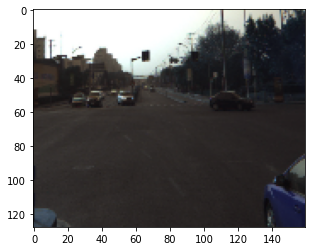

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(x_batch[0]);

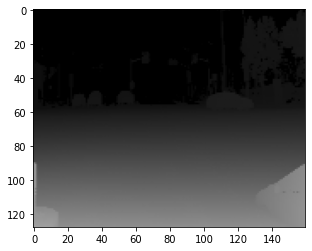

In [ ]:
y_repeat = np.repeat(y_batch[0], 3, axis=-1) # (128, 160, 1) -> (128, 160, 3)
plt.imshow(y_repeat);

## appraoch 2: as above but more training examples

In [ ]:

def load_dataset(name, split_seed=0, test_fraction=.1, return_as_tensor=False):
    # load full dataset
    load_funs = { 
                #   "wine"              : _load_wine,
                #   "boston"            : _load_boston,
                #   "concrete"          : _load_concrete,
                #   "power-plant"       : _load_powerplant,
                #   "yacht"             : _load_yacht,
                #   "energy-efficiency" : _load_energy_efficiency,
                #   "kin8nm"            : _load_kin8nm,
                #   "naval"             : _load_naval,
                #   "protein"           : _load_protein,
                  "depth"              : _load_depth,
                #   "song"              : _load_song,
                 }

    print("Loading dataset {}....".format(name))
    if name == "depth":
        (X_train, y_train), (X_test, y_test) = load_funs[name]()
        y_scale = np.array([[1.0]])
        return (X_train, y_train), (X_test, y_test), y_scale

    X, y = load_funs[name]()
    X = X.astype(np.float32)
    y = y.astype(np.float32)
    def standardize(data):
        mu = data.mean(axis=0, keepdims=1)
        scale = data.std(axis=0, keepdims=1)
        scale[scale<1e-10] = 1.0

        data = (data - mu) / scale
        return data, mu, scale



    # We create the train and test sets with 90% and 10% of the data

    if split_seed == -1:  # Do not shuffle!
        permutation = range(X.shape[0])
    else:
        rs = np.random.RandomState(split_seed)
        permutation = rs.permutation(X.shape[0])

    if name == "boston" or name == "wine":
        test_fraction = 0.2
    size_train  = int(np.round(X.shape[ 0 ] * (1 - test_fraction)))
    index_train = permutation[ 0 : size_train ]
    index_test  = permutation[ size_train : ]

    X_train = X[ index_train, : ]
    X_test  = X[ index_test, : ]

    if name == "depth":
        y_train = y[index_train]
        y_test = y[index_test]
    else:
        y_train = y[index_train, None]
        y_test = y[index_test, None]


    X_train, x_train_mu, x_train_scale = standardize(X_train)
    X_test = (X_test - x_train_mu) / x_train_scale

    y_train, y_train_mu, y_train_scale = standardize(y_train)
    y_test = (y_test - y_train_mu) / y_train_scale

    if return_as_tensor:
        X_train = tf.convert_to_tensor(X_train, tf.float32)
        X_test = tf.convert_to_tensor(X_test, tf.float32)
        y_train = tf.convert_to_tensor(y_train, tf.float32)
        y_test = tf.convert_to_tensor(y_test, tf.float32)

    print("Done loading dataset {}".format(name))
    return (X_train, y_train), (X_test, y_test), y_train_scale

In [ ]:
from tqdm.notebook import tqdm

batch_size = 32

# datasets = load_dataset("depth")[0]
# x = datasets[0]
# y = datasets[1]
# ood = False

(X_train, y_train), (X_test, y_test), y_train_scale = load_dataset('depth', return_as_tensor=True)
# x = X_train
# y = y_train
# ood = False

# for start_i in tqdm(np.arange(0, 3*batch_size, batch_size)):
#     inds = np.arange(start_i, min(start_i+batch_size, x.shape[0]-1))
#     x_batch = x[inds]/np.float32(255.)
#     y_batch = y[inds]/np.float32(255.)

Loading dataset depth....


In [ ]:
# X_train /= np.array(255.)
# y_train /= np.array(255.)

# scale = tf.constant(255., tf.float32)
# scale

In [ ]:
type(X_train)

h5py._hl.dataset.Dataset

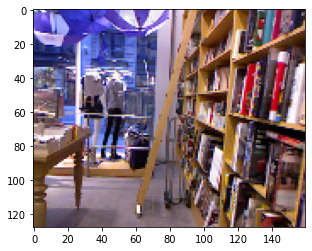

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(X_train[22260]);

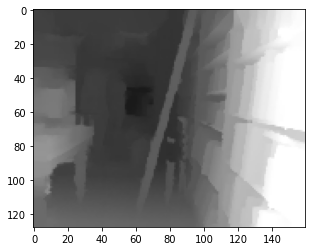

In [ ]:
y_repeat = np.repeat(y_train[22260], 3, axis=-1) # (128, 160, 1) -> (128, 160, 3)
plt.imshow(y_repeat);

# First overfit a simple model (not capsa)

https://github.com/keras-team/keras-io/blob/master/examples/vision/ipynb/depth_estimation.ipynb

In [27]:
HEIGHT = 128
WIDTH = 160
LR = 0.0002
EPOCHS = 30
BATCH_SIZE = 32

In [28]:
class DownscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()

        self.pool = layers.MaxPool2D((2, 2), (2, 2))

    def call(self, input_tensor):
        d = self.convA(input_tensor)
        x = self.bn2a(d)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        x += d
        p = self.pool(x)
        return x, p


class UpscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.us = layers.UpSampling2D((2, 2))
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()
        self.conc = layers.Concatenate()

    def call(self, x, skip):
        x = self.us(x)
        concat = self.conc([x, skip])
        x = self.convA(concat)
        x = self.bn2a(x)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        return x


class BottleNeckBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)

    def call(self, x):
        x = self.convA(x)
        x = self.reluA(x)
        x = self.convB(x)
        x = self.reluB(x)
        return x

In [29]:
class DepthEstimationModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.ssim_loss_weight = 0.85
        self.l1_loss_weight = 0.1
        self.edge_loss_weight = 0.9
        self.loss_metric = tf.keras.metrics.Mean(name="loss")
        f = [16, 32, 64, 128, 256]
        self.downscale_blocks = [
            DownscaleBlock(f[0]),
            DownscaleBlock(f[1]),
            DownscaleBlock(f[2]),
            DownscaleBlock(f[3]),
        ]
        self.bottle_neck_block = BottleNeckBlock(f[4])
        self.upscale_blocks = [
            UpscaleBlock(f[3]),
            UpscaleBlock(f[2]),
            UpscaleBlock(f[1]),
            UpscaleBlock(f[0]),
        ]
        self.conv_layer = layers.Conv2D(1, (1, 1), padding="same", activation="tanh")

    def calculate_loss(self, target, pred):
        # Edges
        dy_true, dx_true = tf.image.image_gradients(target)
        dy_pred, dx_pred = tf.image.image_gradients(pred)
        weights_x = tf.exp(tf.reduce_mean(tf.abs(dx_true)))
        weights_y = tf.exp(tf.reduce_mean(tf.abs(dy_true)))

        # Depth smoothness
        smoothness_x = dx_pred * weights_x
        smoothness_y = dy_pred * weights_y

        depth_smoothness_loss = tf.reduce_mean(abs(smoothness_x)) + tf.reduce_mean(
            abs(smoothness_y)
        )

        # Structural similarity (SSIM) index
        ssim_loss = tf.reduce_mean(
            1
            - tf.image.ssim(
                target, pred, max_val=WIDTH, filter_size=7, k1=0.01 ** 2, k2=0.03 ** 2
            )
        )
        # Point-wise depth
        l1_loss = tf.reduce_mean(tf.abs(target - pred))

        loss = (
            (self.ssim_loss_weight * ssim_loss)
            + (self.l1_loss_weight * l1_loss)
            + (self.edge_loss_weight * depth_smoothness_loss)
        )

        return loss

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch_data):
        input, target = batch_data
        with tf.GradientTape() as tape:
            pred = self(input, training=True)
            loss = self.calculate_loss(target, pred)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }

    def test_step(self, batch_data):
        input, target = batch_data

        pred = self(input, training=False)
        loss = self.calculate_loss(target, pred)

        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }

    def call(self, x):
        c1, p1 = self.downscale_blocks[0](x)
        c2, p2 = self.downscale_blocks[1](p1)
        c3, p3 = self.downscale_blocks[2](p2)
        c4, p4 = self.downscale_blocks[3](p3)

        bn = self.bottle_neck_block(p4)

        u1 = self.upscale_blocks[0](bn, c4)
        u2 = self.upscale_blocks[1](u1, c3)
        u3 = self.upscale_blocks[2](u2, c2)
        u4 = self.upscale_blocks[3](u3, c1)

        return self.conv_layer(u4)

In [30]:
# (X_train, y_train), (X_test, y_test), y_train_scale = load_dataset('depth')

### https://github.com/aamini/evidential-deep-learning/blob/main/neurips2020/train_depth.py#L34
(x_train, y_train), (x_test, y_test) = load_depth()

In [31]:
x_train = tf.convert_to_tensor(x_train[:1024], tf.float32)
y_train = tf.convert_to_tensor(y_train[:1024], tf.float32)

x_train /= 255.
y_train /= 255.

Epoch 1/30
32/32 [==============================] - 3s 45ms/step - loss: 0.6551
Epoch 2/30
32/32 [==============================] - 1s 46ms/step - loss: 0.2277
Epoch 3/30
32/32 [==============================] - 2s 47ms/step - loss: 0.1918
Epoch 4/30
32/32 [==============================] - 2s 47ms/step - loss: 0.1312
Epoch 5/30
32/32 [==============================] - 1s 45ms/step - loss: 0.1201
Epoch 6/30
32/32 [==============================] - 2s 48ms/step - loss: 0.1015
Epoch 7/30
32/32 [==============================] - 1s 47ms/step - loss: 0.0905
Epoch 8/30
32/32 [==============================] - 1s 45ms/step - loss: 0.0856
Epoch 9/30
32/32 [==============================] - 1s 46ms/step - loss: 0.0746
Epoch 10/30
32/32 [==============================] - 1s 47ms/step - loss: 0.0682
Epoch 11/30
32/32 [==============================] - 1s 46ms/step - loss: 0.0670
Epoch 12/30
32/32 [==============================] - 1s 46ms/step - loss: 0.0624
Epoch 13/30
32/32 [==================

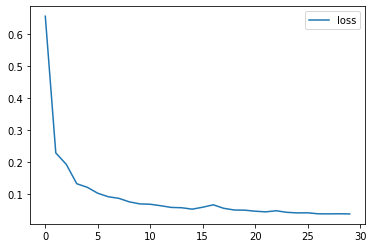

In [32]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LR,
    amsgrad=False,
)

model = DepthEstimationModel()

# Define the loss function
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)
# Compile the model
model.compile(optimizer, loss=cross_entropy)

# train_loader = DataGenerator(
#     data=df[:260].reset_index(drop="true"), batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH)
# )
# validation_loader = DataGenerator(
#     data=df[260:].reset_index(drop="true"), batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH)
# )

history = model.fit(
    # train_loader,
    x_train,
    y_train,
    epochs=EPOCHS,
    # validation_data=validation_loader,
)
plot_loss(history)

/tmp/ipykernel_3705292/991743973.py:5: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("jet").copy()
  cmap.set_bad(color="black")


32/32 [==============================] - 1s 13ms/step


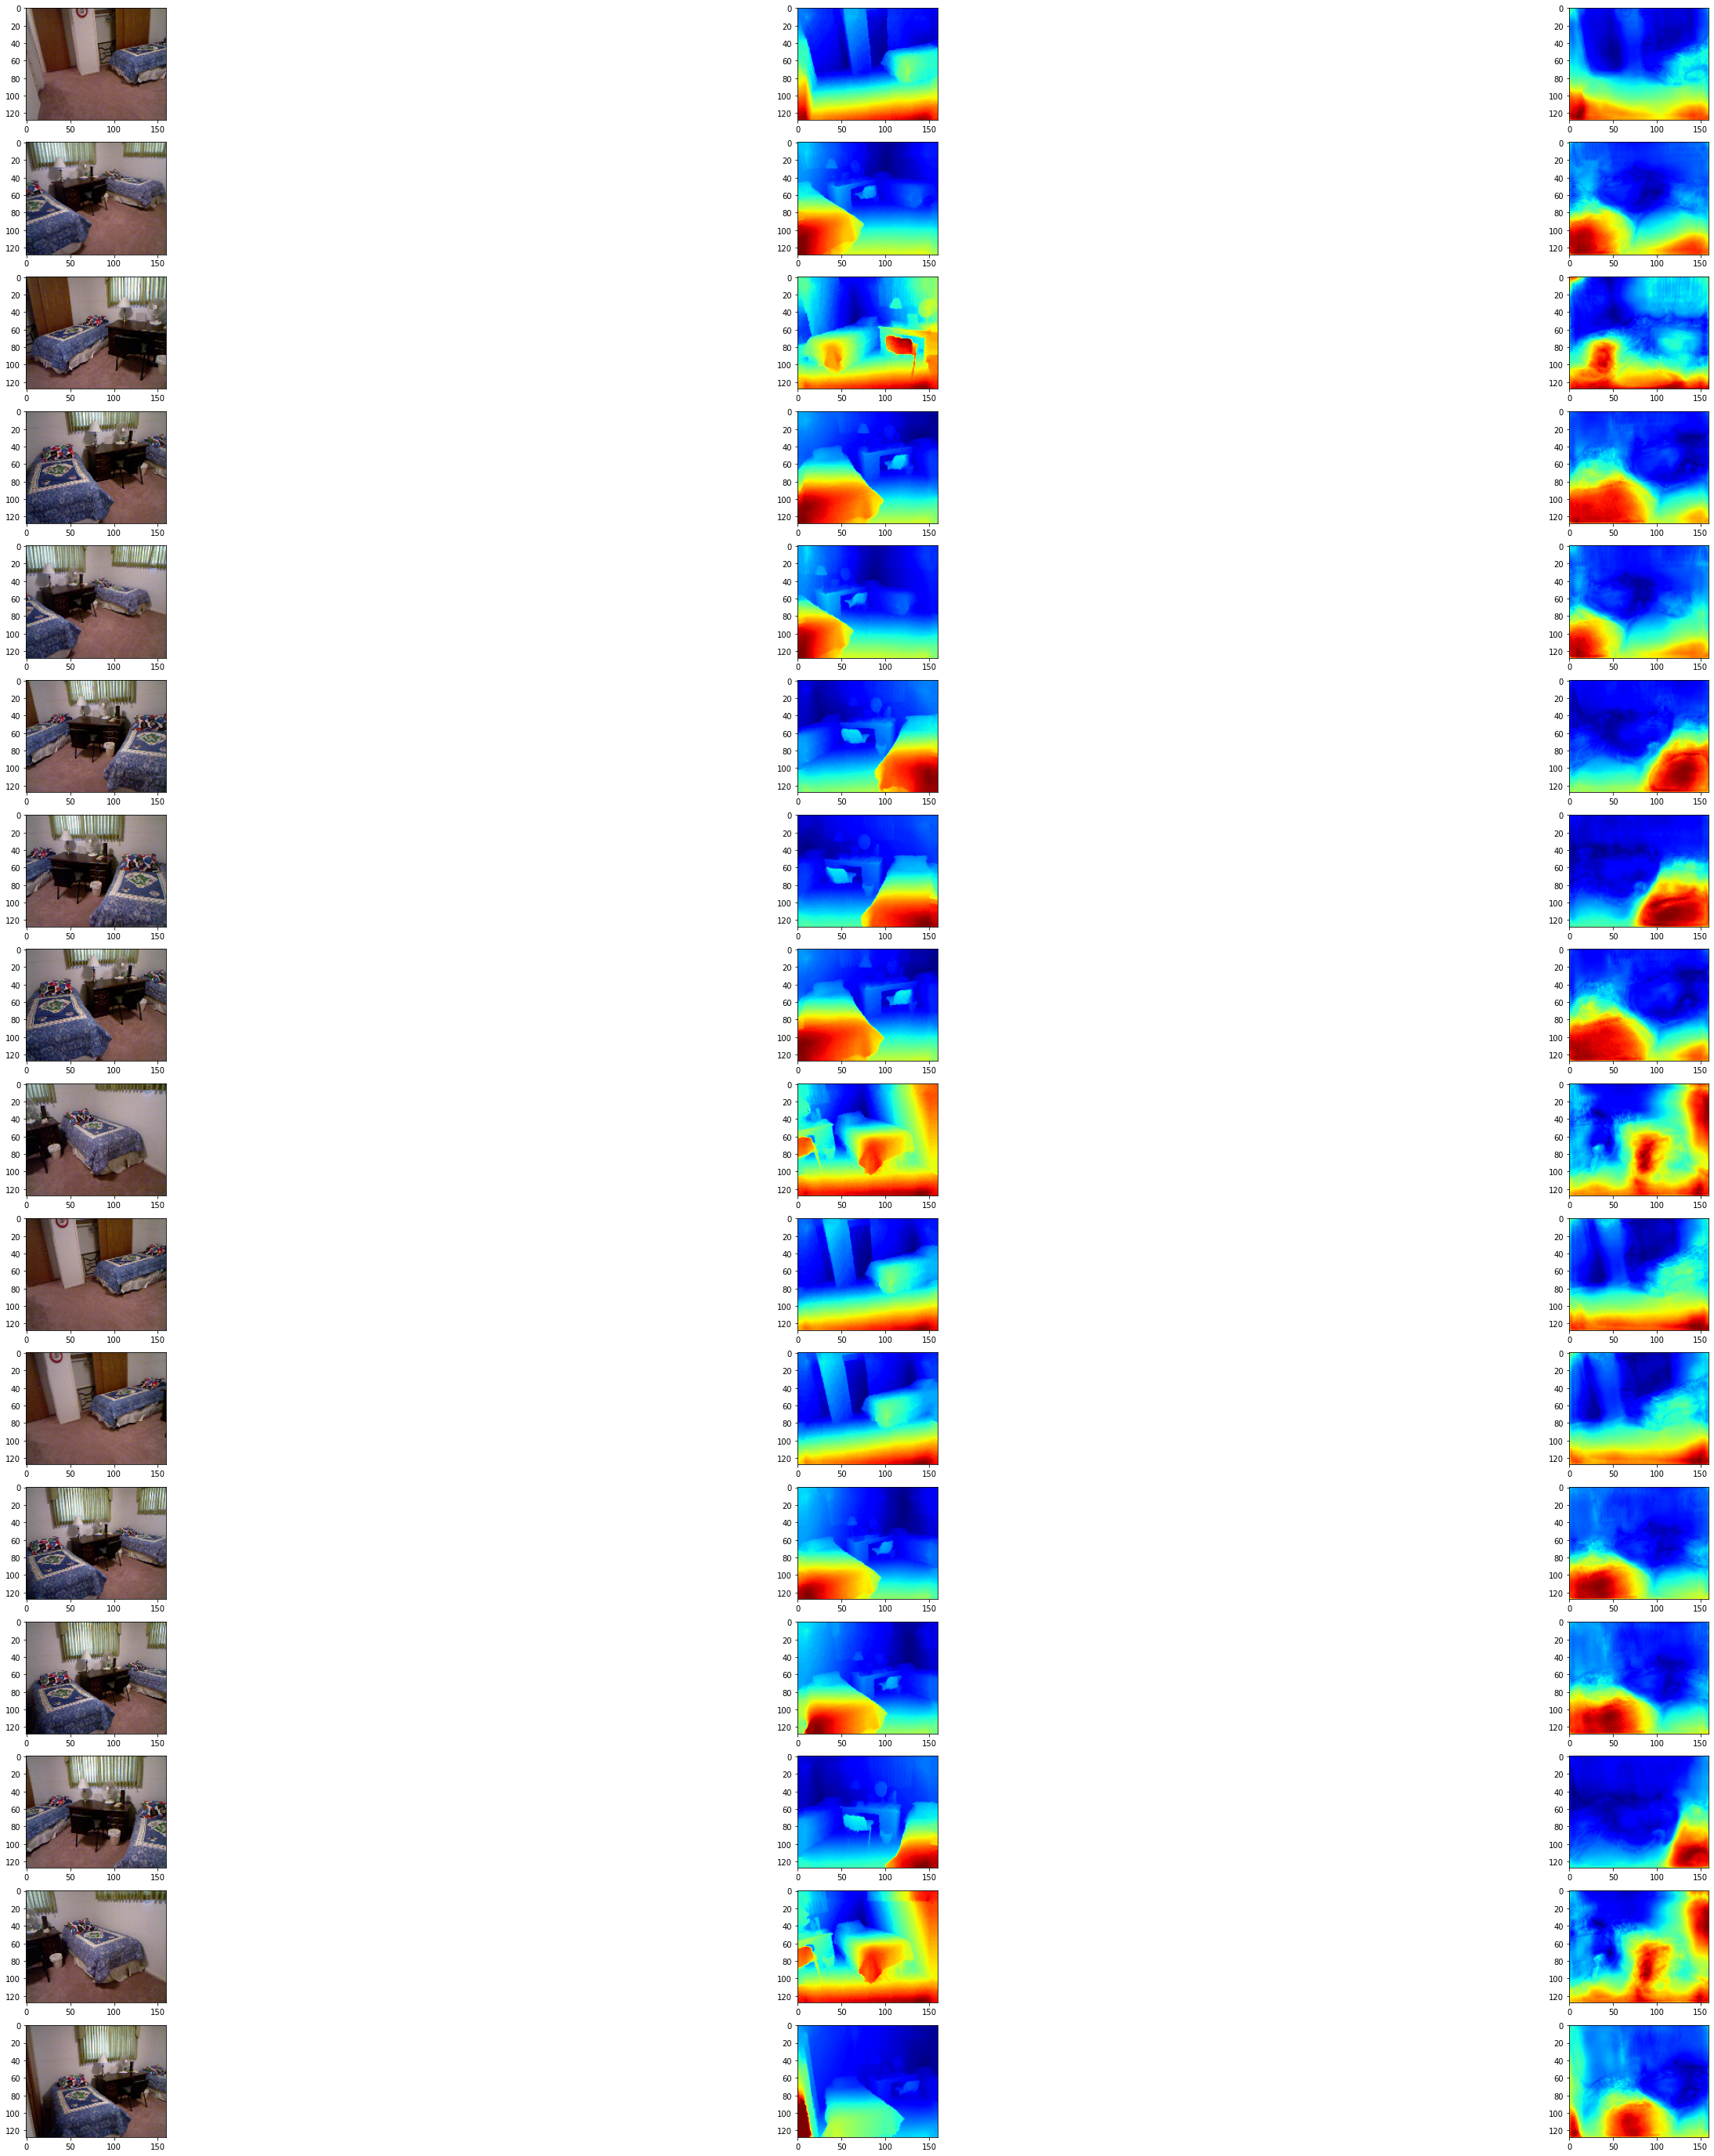

In [33]:
visualize_depth_map(x_train, y_train, model)

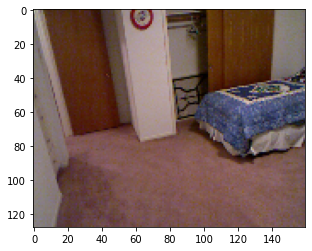

In [12]:
plt.imshow(x_train[0])

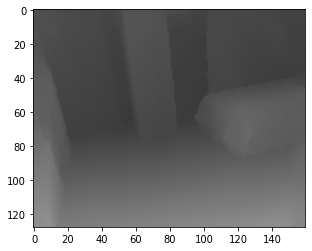

In [13]:
plt.imshow(tf.repeat(y_train[0], 3, -1))

2022-08-11 05:25:12.595558: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


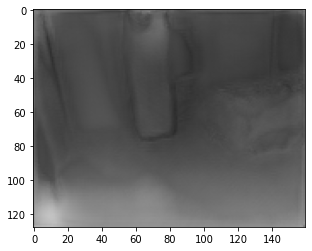

In [15]:
out = model(x_train[:16], training=False)
plt.imshow(tf.repeat(out[0], 3, -1)) # (128, 160, 1) -> (128, 160, 3)

## – pytorch

In [ ]:
# class DoubleConv(nn.Module):

#     def __init__(self, in_c, out_c):
#         super(DoubleConv, self).__init__()
        
#         # same padding: int(1 + ("H"256 - "HH"3 + 2*"pad"1) / "stride"1) = 256
#         self.block = nn.Sequential(
#                         nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, bias=False),
#                         nn.BatchNorm2d(out_c),
#                         nn.ReLU(True),
#                         nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, bias=False),
#                         nn.BatchNorm2d(out_c),
#                         nn.ReLU(True),
#                         )

#     def forward(self, x):
#         return(self.block(x)) 


# class Unet(nn.Module):

#     """ Implementation of Unet - https://arxiv.org/abs/1505.04597

#     # input (B, in_c=3, H, W)
#     # output (B, out_c=num_classes, H, W)
#     """

#     def __init__(self, in_c, out_c, mid_c=[64, 128, 256, 512]):
#         super(Unet, self).__init__()

#         self.in_c = in_c
#         self.out_c = out_c

#         self.encoder = nn.ModuleList()
#         for out_c in mid_c:
#             self.encoder.append(DoubleConv(in_c, out_c))
#             in_c = out_c

#         self.decoder = nn.ModuleList()
#         for out_c in reversed(mid_c):
#             in_c = out_c*2
#             self.decoder.append(nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2))
#             # use (in_c, out_c) again, bc we add a skip connetion to the output of ConvTrans2d
#             self.decoder.append(DoubleConv(in_c, out_c))

#         self.bottleneck = DoubleConv(mid_c[-1], mid_c[-1]*2)
#         self.final_conv = nn.Conv2d(mid_c[0], self.out_c, kernel_size=1)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)


#     def forward(self, x):

#         skips = []
#         for down_block in self.encoder:
#             x = down_block(x) #3-> 64-> 128 -> 256-> 512
#             skips.append(x)
#             x = self.pool(x)

#         x = self.bottleneck(x) #512-> 1024

#         skips = skips[::-1]
#         for idx in range(0, len(self.decoder), 2):
#             # transposed conv
#             x = self.decoder[idx](x)
#             # add skip
#             assert(skips[idx//2].shape == x.shape)
#             x = torch.cat((skips[idx//2], x), dim=1) # on channel dim
#             # double conv
#             x = self.decoder[idx+1](x)

#         return self.final_conv(x)


# def check_channels():
#     net = Unet(3, 13)
#     x = torch.randn(10, 3, 256, 256)
#     print(net(x).shape)

# – Define model (capsa)

In [ ]:
#@title ensamble wrapper

import tensorflow as tf
from tensorflow import keras
from keras import optimizers as optim


class EnsembleWrapper(keras.Model):

    def __init__(self, base_model, metric_wrapper=None, num_members=1, is_standalone=True):
        super(EnsembleWrapper, self).__init__()

        self.metric_name = 'ensemble'
        self.is_standalone = is_standalone
        self.base_model = base_model

        self.metric_wrapper = metric_wrapper
        self.num_members = num_members
        self.metrics_compiled = {}

    def compile(self, optimizer, loss, metrics=[None]):
        super(EnsembleWrapper, self).compile()

        # if user passes only 1 optimizer and loss_fn yet they specified e.g. num_members=3, 
        # duplicate that one optimizer and loss_fn for all members in the ensemble
        if len(optimizer) or len(loss) < self.num_members:
            optim_conf = optim.serialize(optimizer[0])
            optimizer = [optim.deserialize(optim_conf) for _ in range(self.num_members)]
            # losses and *most* keras metrics are stateless, no need to serialize as above
            loss = [loss[0] for _ in range(self.num_members)]
            metrics = [metrics[0] for _ in range(self.num_members)]

        base_model_config = self.base_model.get_config()
        assert base_model_config != {}, 'Please implement get_config().'

        for i in range(self.num_members):

            if isinstance(self.base_model, keras.Sequential):
                m = keras.Sequential.from_config(base_model_config)
            elif isinstance(self.base_model, keras.Model):
                m = keras.Model.from_config(base_model_config)
            else:
                raise Exception('Please provide a Sequential, Functional or subclassed model.')

            m = m if self.metric_wrapper is None else self.metric_wrapper(m, self.is_standalone)
            m_name = f'usermodel_{i}' if self.metric_wrapper is None else f'{m.metric_name}_{i}'
            m.compile(optimizer[i], loss[i], metrics[i])
            self.metrics_compiled[m_name] = m

    def train_step(self, data):
        keras_metrics = {}

        for name, wrapper in self.metrics_compiled.items():

            # ensembling user model
            if self.metric_wrapper is None:
                _ = wrapper.train_step(data)
                for m in wrapper.metrics:
                    keras_metrics[f'{name}_{m.name}'] = m.result()

            # ensembling one of our metrics
            else:
                keras_metric = wrapper.train_step(data, name)
                keras_metrics.update(keras_metric)

        return keras_metrics

    # def wrapped_train_step(self, x, y, features, prefix):
    #     keras_metrics = {}

    #     accum_grads = tf.zeros_like(features)
    #     scalar = 1 / self.num_members

    #     for name, wrapper in self.metrics_compiled.items():
    #         keras_metric, grad = wrapper.wrapped_train_step(x, y, features, f'{prefix}_{name}')
    #         keras_metrics.update(keras_metric)
    #         accum_grads += tf.scalar_mul(scalar, grad[0])
    #     return keras_metrics, [accum_grads]

    def call(self, x, training=False, return_risk=True, features=None):
        outs = []
        for wrapper in self.metrics_compiled.values():

            # ensembling the user model
            if self.metric_wrapper is None:
                out = wrapper(x)

            # ensembling one of our own metrics
            else:
                out = wrapper(x, training, return_risk, features)
            outs.append(out)

        return outs

## tran on old problem

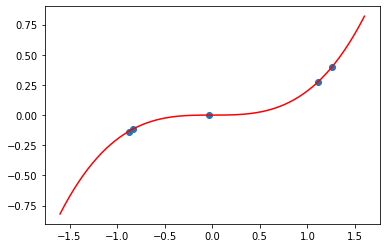

Epoch 1/100
1/1 [==============================] - 3s 3s/step - usermodel_0_loss: 0.0597 - usermodel_1_loss: 0.0570 - usermodel_2_loss: 0.0737 - usermodel_3_loss: 0.0555 - usermodel_4_loss: 0.0503
Epoch 2/100
1/1 [==============================] - 0s 22ms/step - usermodel_0_loss: 0.0420 - usermodel_1_loss: 0.0372 - usermodel_2_loss: 0.0471 - usermodel_3_loss: 0.0422 - usermodel_4_loss: 0.0276
Epoch 3/100
1/1 [==============================] - 0s 18ms/step - usermodel_0_loss: 0.0341 - usermodel_1_loss: 0.0263 - usermodel_2_loss: 0.0336 - usermodel_3_loss: 0.0333 - usermodel_4_loss: 0.0198
Epoch 4/100
1/1 [==============================] - 0s 18ms/step - usermodel_0_loss: 0.0279 - usermodel_1_loss: 0.0202 - usermodel_2_loss: 0.0263 - usermodel_3_loss: 0.0279 - usermodel_4_loss: 0.0171
Epoch 5/100
1/1 [==============================] - 0s 20ms/step - usermodel_0_loss: 0.0235 - usermodel_1_loss: 0.0167 - usermodel_2_loss: 0.0228 - usermodel_3_loss: 0.0245 - usermodel_4_loss: 0.0138
Epoch 6

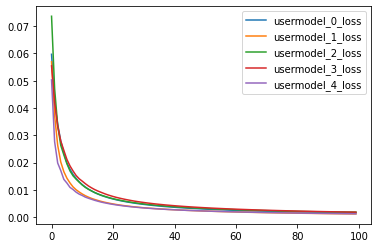

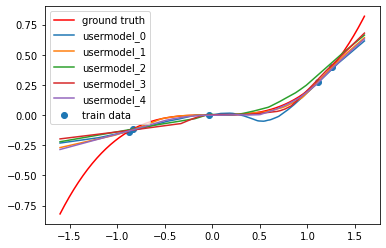

In [ ]:
their_model = get_user_model()
x, y, x_val, y_val = get_data_v1()

model = EnsembleWrapper(their_model, num_members=5)
model.compile(
    optimizer=[keras.optimizers.Adam(learning_rate=1e-2)],
    loss=[keras.losses.MeanSquaredError()],
    # metrics=[[
    #     # keras.metrics.MeanSquaredError(name='mse'),
    #     keras.metrics.CosineSimilarity(name='cos'),
    # ]],
)

history = model.fit(x, y, epochs=100)
plot_loss(history)

outs = model(x_val)
preds_names = get_preds_names(history)

plt.plot(x_val, y_val, 'r-', label="ground truth")
plt.scatter(x, y, label="train data")
for i, out in enumerate(outs):
    plt.plot(x_val, out, label=preds_names[i])
plt.legend(loc='upper left')
plt.show()

## Train on depth

In [ ]:
their_model = create(X_train[0].shape) #(128, 160, 3)
print(their_model(np.random.rand(1, 128, 160, 3)).shape)

model = EnsembleWrapper(their_model, num_members=1)
model.compile(
    optimizer=[keras.optimizers.Adam(learning_rate=5e-5)], #5e-5
    loss=[keras.losses.MeanSquaredError()],
    # metrics=[[
    #     # keras.metrics.MeanSquaredError(name='mse'),
    #     keras.metrics.CosineSimilarity(name='cos'),
    # ]],
)
print(model(np.random.rand(1, 128, 160, 3))[0].shape)

# https://github.com/keras-team/keras/issues/628#issuecomment-137501087
history = model.fit(X_train, y_train, epochs=1000, batch_size=32, shuffle=False)
plot_loss(history)